In [1]:
#import prediction_arguments
import json
import torch
import numpy as np
from PIL import Image
from torchvision import models, transforms
import sys
import os
import base64
import warnings
import argparse
from IPython.display import Image as DisplayImage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# To ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
def load_the_model(device, model):

    dict_model = torch.load(model)
    model = models.__dict__[dict_model["arch"]](pretrained=True)
    model.classifier = dict_model["classifier"]
    model.class_to_idx = dict_model["class_to_idx"]
    model.load_state_dict(dict_model["state_dict"])
    model.to(device)




    return model


def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    min_dimension = 0

    if image.size[1] < image.size[0]:
        min_dimension = 1

    if min_dimension == 0:
        image.thumbnail((256, image.size[1]))
    else:
        image.thumbnail((image.size[0], 256))

    ##### come of these transforms can and should be done via transforms.Compose()

    ########### crop
    box = ((image.width-224)/2, (image.height-224)/2, (image.width-224)/2 + 224, (image.height-224)/2 + 224 )
    image = image.crop(box = box)

    ########### convert
    image = np.array(image)/255
    image = (image - np.array([0.485, 0.456, 0.406]) )/np.array([0.229, 0.224, 0.225])


    #########transpose, hope it does what it's supposed to do
    image = image.transpose( (2, 0, 1) )


    return image


def predict(image_path, model, topk, device):

    ''' Predict the class (or classes) of an image using a trained deep learning model.'''
    im = Image.open(image_path)
    numpy_im = process_image(im)



    if device.type == "cuda":
        images = torch.from_numpy(numpy_im).type(torch.cuda.FloatTensor)
    else:
        images = torch.from_numpy(numpy_im).type(torch.FloatTensor)

#     print(images.shape)


    images.unsqueeze_(0)
#     print(images.shape)


    with torch.no_grad():
        model.eval()
        log_probs = model(images)
    probs = torch.exp(log_probs)
    top_probs, top_classes = probs.topk(topk)





    idx_into_class = {y: x for x, y in model.class_to_idx.items()}


    ########into lists
    top_probs = top_probs.cpu().numpy()
    top_probs = top_probs.tolist()[0]

    top_classes = top_classes.cpu().numpy()
    top_classes = top_classes.tolist()[0]




    actual_names = [idx_into_class[model_out_class].split("-", 1)[-1].strip() for model_out_class in top_classes]



    return top_probs,actual_names




def create_output_file(image_path, model_checkpoint, device, top_probs, actual_names):
    # Define the path to the output text file
    output_file_path = "output.txt"

    # Redirect standard output to the text file
    with open(output_file_path, 'w') as file:
        sys.stdout = file

        # Print the path to the image
        print("Current image: {}".format(image_path))

        # Check if the image file exists
        if os.path.isfile(image_path):
            # Open the file in binary write mode ('wb') to write binary data
            with open(image_path, 'rb') as image_file:
                image_data = image_file.read()
                # Write the binary image data directly to the file
                file.buffer.write(image_data)

        # Add a clear delimiter or separator
        file.write("\n--- Image Data Ends Here ---\n")

        print("-------------------------------------------")
        print("Model: {}".format(model_checkpoint))
        print("Device: {}".format(device))

        print("-------------------------------------------")
        print("Our predictions:")
        print("The dog is {}".format(actual_names[0]))

        print("-------------------------------------------")
        print("Top possibilities are: ")
        for i in range(len(top_probs)):
            print("the dog is {} with probability {:.2f}".format(actual_names[i], top_probs[i]))

    # Restore standard output to the console
    sys.stdout = sys.__stdout__

In [3]:



def main():
    """
    Predictions are happening here!
    """

    
    print(" One moment plaese, Prediction is going on...!")
    
    
    #CPU OR GPU?
    device = torch.device("cpu")
    if args.gpu:
        device = torch.device("cuda")

    model = load_the_model(device, args.model)

    top_probs, actual_names = predict(args.path_to_image, model, args.top_k, device)
    print(" ")

    print(" Here is the image of the dog that we want to predict.")
    # Path to the image you want to display
    image_path = args.path_to_image

    # Display the image using imshow
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Optional: Hide axis labels
    plt.show()

    print(" ")
    
    print(" Current image: {}".format(args.path_to_image))
    print(" Model: {}".format(args.model))
    print(" Device: {}".format(device))
    print(" ")

    print(" ")

    print(" =======================================================")
    print(" OUR PREDICTION:")
    print(" The dog is {} ".format(actual_names[0]))
    print(" =======================================================")

    print(" ")


    print(" Top possibilities are: ")
    for i in range(len(top_probs)):
        print(" The dog is {} with probability {:.2f}".format(actual_names[i], top_probs[i]))

    #create_output_file(args.path_to_image, args.checkpoint, device, top_probs, actual_names)


Enter the image path and model path Below

 One moment plaese, Prediction is going on...!
 
 Here is the image of the dog that we want to predict.


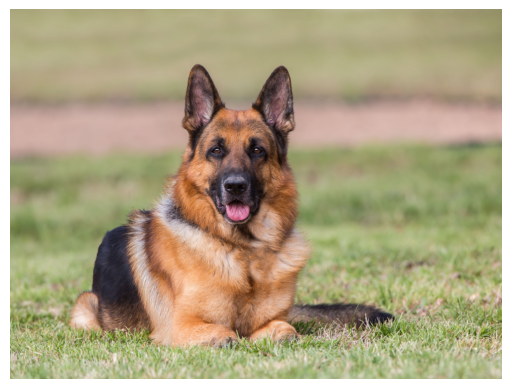

 
 Current image: ./dog_example2.jpg
 Model: ./model.pth
 Device: cuda
 
 
 OUR PREDICTION:
 The dog is German_shepherd 
 
 Top possibilities are: 
 The dog is German_shepherd with probability 0.99
 The dog is Cardigan with probability 0.01
 The dog is malinois with probability 0.00


In [4]:
args = argparse.Namespace(
    path_to_image="./dog_example2.jpg",
    model="./model.pth",
    top_k=3,
    gpu=True
)

main()